In [44]:
import gc
import re

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
nlp = spacy.load('en_core_web_sm')

# 50
train, valid,test set に分ける

In [3]:
df = pd.read_csv(
    './NewsAggregatorDataset/newsCorpora.csv', 
    delimiter="\t", 
    header=None)

In [4]:
df.columns =  ['id', 'title','url', 'publisher', 'category', 'story', 'hostname', 'timestamp']

In [5]:
df = df[df['publisher'].isin(['Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]

In [6]:
df = df.sample(frac=1.0).reset_index(drop=True)

In [7]:
trn_frac = 0.8
val_frac = 0.1
test_frac = 0.1

In [8]:
trn_num = int(len(df)*trn_frac)
val_num = int(len(df)*val_frac)
test_num = len(df) - (trn_num+val_num)
print(f"train sample: {trn_num}")
print(f"val sample: {val_num}")
print(f"test sample: {test_num}")
assert len(df) == (trn_num + val_num + test_num)

train sample: 7550
val sample: 943
test sample: 945


In [9]:
df.iloc[:trn_num][['title', 'category']].to_csv('train.txt', sep="\t", index=False)

In [10]:
df.iloc[trn_num:trn_num+val_num][['title', 'category']].to_csv('valid.txt', sep="\t", index=False)

In [11]:
df.iloc[-test_num:][['title', 'category']].to_csv('test.txt', sep="\t", index=False)

In [12]:
del df
gc.collect()

60

各カテゴリの事例数の確認

In [3]:
train_df = pd.read_csv('train.txt', delimiter='\t')
train_df.category.value_counts()

e    4102
b    1946
t     909
m     593
Name: category, dtype: int64

In [4]:
valid_df = pd.read_csv('valid.txt', delimiter='\t')
valid_df.category.value_counts()

e    496
b    249
t    125
m     73
Name: category, dtype: int64

In [5]:
test_df = pd.read_csv('test.txt', delimiter='\t')
test_df.category.value_counts()

e    497
b    275
t    114
m     59
Name: category, dtype: int64

# 51
特徴量を抽出して、ファイルに保存する  

テキストのクリーニングとトークナイズ

In [6]:
# ulrの削除
def remove_url(text):
    url_pat = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pat, ' ', text)
    return text

# 小文字化
def lower_text(text):
    return text.lower()

# トークン化
def tokenize(text):
    tokens = ' '.join([str(token) for token in nlp.make_doc(text) if str(token) != ' '])
    return tokens

def preporcessing(text):
    text = lower_text(text)
    text = remove_url(text)
    tokens = tokenize(text)
    return tokens

In [7]:
train_title_tokenized = train_df['title'].apply(preporcessing).values.tolist()
valid_title_tokenized = valid_df['title'].apply(preporcessing).values.tolist()
test_title_tokenized = test_df['title'].apply(preporcessing).values.tolist()

In [45]:
train_title_tokenized[:10]

["kiefer sutherland issues professional response to freddie prinze jr . 's ...",
 'soaring to the top ! rare copy of superman comic book fetches $ 3.2million',
 'treasuries drop a 4th day on speculation rally gains excessive',
 "' hedwig and the angry inch ' on broadway is going to be amazing",
 "monet from huguette clark 's dining room sells for $ 24million at auction",
 'celebrity photographer terry richardson defends himself against sexual ...',
 "chris martin stars as lovestruck magician 's assistant in coldplay 's magic video",
 'claire danes puts on a brave face as she arrives in canada with son cyrus after ...',
 'guardians of the galaxy movie review',
 'pippa middleton looks cool and chic in forties - inspired playsuit for laid back ...']

ベクトル化  
trainのみでfitさせてvalidとtestをtransformする

In [9]:
encoder = CountVectorizer()
encoder.fit(train_title_tokenized)

CountVectorizer()

In [10]:
train_title_feature = encoder.transform(train_title_tokenized)
train_title_feature = pd.DataFrame(train_title_feature.toarray())

valid_title_feature = encoder.transform(valid_title_tokenized)
valid_title_feature = pd.DataFrame(valid_title_feature.toarray())

test_title_feature = encoder.transform(test_title_tokenized)
test_title_feature = pd.DataFrame(test_title_feature.toarray())

In [11]:
train_title_feature.to_csv('train.feature.txt', sep='\t', header=None, index=False)
valid_title_feature.to_csv('valid.feature.txt', sep='\t', header=None, index=False)
test_title_feature.to_csv('test.feature.txt', sep='\t', header=None, index=False)

# 52
学習

In [12]:
train_title_feature = pd.read_csv('train.feature.txt', delimiter='\t', header=None)
valid_title_feature = pd.read_csv('valid.feature.txt', delimiter='\t', header=None)
test_title_feature = pd.read_csv('test.feature.txt', delimiter='\t', header=None)

train_df = pd.read_csv('train.txt', delimiter='\t')
valid_df = pd.read_csv('valid.txt', delimiter='\t')
test_df = pd.read_csv('test.txt', delimiter='\t')

In [13]:
rog_reg = LogisticRegression(max_iter=1000)
rog_reg.fit(train_title_feature, train_df.category)

LogisticRegression(max_iter=1000)

# 53
予測

In [14]:
rog_reg.classes_

array(['b', 'e', 'm', 't'], dtype=object)

In [15]:
def predict(feature):
    probas = rog_reg.predict_proba(feature)
    preds = np.array([rog_reg.classes_[i] for i in np.argmax(probas, axis=1)])
    return preds, probas

In [16]:
train_preds, train_probas = predict(train_title_feature)
test_preds, test_probas = predict(test_title_feature)

In [18]:
print(test_preds[:5])
print(test_probas[:5, :])

['b' 'e' 'e' 'b' 'm']
[[0.98174785 0.00203946 0.00491359 0.01129911]
 [0.02899676 0.85588226 0.02692239 0.0881986 ]
 [0.00872326 0.94624795 0.03881936 0.00620943]
 [0.9802797  0.01059892 0.00261946 0.00650192]
 [0.01402873 0.00195517 0.95552888 0.02848722]]


# 54
正解率の算出

In [19]:
print(f"train acc : {accuracy_score(train_df.category, train_preds)}")
print(f"test acc : {accuracy_score(test_df.category, test_preds)}")

train acc : 0.9973509933774835
test acc : 0.8804232804232804


# 55
混同行列

In [20]:
confusion_matrix(train_preds, train_df.category)

array([[1940,    2,    0,    6],
       [   2, 4100,    2,    4],
       [   0,    0,  591,    0],
       [   4,    0,    0,  899]])

In [21]:
confusion_matrix(test_preds, test_df.category)

array([[231,   9,   6,   4],
       [ 25, 480,  15,  21],
       [  4,   1,  36,   4],
       [ 15,   7,   2,  85]])

# 56

In [22]:
print(classification_report(test_preds, test_df.category, ))

              precision    recall  f1-score   support

           b       0.84      0.92      0.88       250
           e       0.97      0.89      0.92       541
           m       0.61      0.80      0.69        45
           t       0.75      0.78      0.76       109

    accuracy                           0.88       945
   macro avg       0.79      0.85      0.81       945
weighted avg       0.89      0.88      0.88       945



In [23]:
test_cm = confusion_matrix(test_preds, test_df.category)

In [24]:
test_cm

array([[231,   9,   6,   4],
       [ 25, 480,  15,  21],
       [  4,   1,  36,   4],
       [ 15,   7,   2,  85]])

In [25]:
tp = test_cm.diagonal()
fn = test_cm.sum(axis=1) - tp
fp = test_cm.sum(axis=0) - tp

In [26]:
tp.sum() / (tp + fp).sum()

0.8804232804232804

In [27]:
accuracy  = tp.sum() / (tp + fp).sum()

precision = tp / (tp + fp)

recall = tp / (fn + tp)

f1 = 2 * (precision * recall) / (precision + recall)

In [28]:
print("accuracy:\t", accuracy)
print("precision score:\t", precision)
print("recall score:\t", recall)
print("f1 score:\t", f1)

accuracy:	 0.8804232804232804
precision score:	 [0.84       0.96579477 0.61016949 0.74561404]
recall score:	 [0.924      0.88724584 0.8        0.77981651]
f1 score:	 [0.88       0.92485549 0.69230769 0.76233184]


- マクロ平均：各クラスごとに評価値を算出して算術平均をとる
- マイクロ平均：混同行列全体の値を集計して算出する。FP、FNが丸め込まれるため、recall、precision、f1が正解率に一致する

参考：
- https://analysis-navi.com/?p=553
- https://qiita.com/FukuharaYohei/items/be89a99c53586fa4e2e4

> マクロ平均は単純な算術平均(相加平均)です。調和平均ではありません。各クラスごとの正解率、適合率等の値を平均するだけです(なので式も省略)。
マイクロ平均は各クラスごとの計算をせずに、混合行列全体からTP等の値集計をして算出します。他クラス分類の場合に、全体の合計で考えるのでPositiveとNegativeの区別が丸め込まれるためFPとFNは同一です。そのため、適合率・再現率・F値も同じ値です

> ちなみに、「マクロ平均〜」に対して「マイクロ平均再現率」「マイクロ平均適合率」「マイクロ平均F値」という概念もありますが、多クラス混同行列においては、これらの値は全て「正解率」と一致しますので、除外しています。

In [29]:
macro_precision = precision.sum() / len(precision)
macro_recall = recall.sum() / len(recall)
macro_f1 = f1.sum() / len(f1)

In [30]:
print("macro precision:\t", macro_precision)
print("macro recall:\t", macro_recall)
print("macro f1:\t", macro_f1)

macro precision:	 0.7903945738062033
macro recall:	 0.847765588699147
macro f1:	 0.8148737555505486


In [31]:
# マイクロ平均の評価値はすべて一致する
print(tp.sum() / (tp.sum() + fp.sum()))
print(tp.sum() / (fn.sum() + tp.sum()))
print(accuracy_score(test_preds, test_df.category))
print(recall_score(test_preds, test_df.category, average='micro'))
print(f1_score(test_preds, test_df.category, average='micro'))

0.8804232804232804
0.8804232804232804
0.8804232804232804
0.8804232804232804
0.8804232804232806


# 57
重みの高い特徴量を算出

In [32]:
vocab = encoder.get_feature_names()
class_names = rog_reg.classes_

In [33]:
for cls, coef in zip(class_names, np.argsort(rog_reg.coef_, axis=1)[::-1][:, :10]):
    print("class:", cls)
    for i, j in enumerate(coef):
        print(i, vocab[j])
    print("="*40)

class: b
0 valued
1 american
2 her
3 brand
4 move
5 spotify
6 cancer
7 young
8 last
9 men
class: e
0 facebook
1 amazon
2 gm
3 apple
4 here
5 climate
6 twitter
7 dimon
8 news
9 cars
class: m
0 google
1 facebook
2 billion
3 ceo
4 gm
5 climate
6 china
7 tesla
8 ebola
9 prices
class: t
0 aereo
1 can
2 mother
3 she
4 ebola
5 pump
6 study
7 gay
8 early
9 heart


# 58
正則化パラメーターの変更

In [34]:
scores = []
for C in [0.1,0.5, 1, 5, 10]:
    rog_reg = LogisticRegression(C=C, max_iter=1000)
    rog_reg.fit(train_title_feature, train_df.category)
    
    train_preds = rog_reg.predict(train_title_feature)
    valid_preds = rog_reg.predict(valid_title_feature)
    test_preds = rog_reg.predict(test_title_feature)
    
    train_acc = accuracy_score(train_df.category, train_preds)
    valid_acc = accuracy_score(valid_df.category, valid_preds)
    test_acc = accuracy_score(test_df.category, test_preds)
    
    score = {'C': C, 'train_acc': train_acc, 'valid_acc': valid_acc, 'test_acc': test_acc}
    scores.append(score)

In [35]:
scores = pd.DataFrame(scores)
scores

,C,train_acc,valid_acc,test_acc
0,0.1,0.914834,0.861082,0.842328
1,0.5,0.989801,0.891835,0.871958
2,1.0,0.997351,0.899258,0.880423
3,5.0,0.999603,0.898197,0.881481
4,10.0,0.999603,0.900318,0.880423


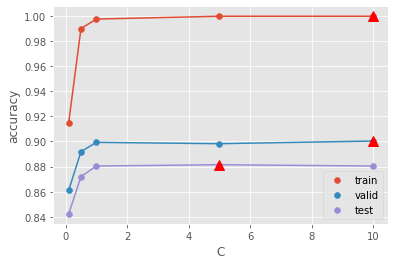

In [36]:
fig = plt.subplot(1,1,1)
fig.scatter(x=scores.C, y=scores.train_acc, label='train')
fig.plot(scores.C, scores.train_acc)

train_max = scores.sort_values(by="train_acc").iloc[-1]
fig.plot(train_max.C, train_max.train_acc, marker='^', markersize=10, color='r')

fig.scatter(x=scores.C, y=scores.valid_acc, label='valid')
fig.plot(scores.C, scores.valid_acc)

valid_max = scores.sort_values(by="valid_acc").iloc[-1]
fig.plot(valid_max.C, valid_max.valid_acc, marker='^', markersize=10, color='r')

fig.scatter(x=scores.C, y=scores.test_acc, label='test')
fig.plot(scores.C, scores.test_acc)

test_max = scores.sort_values(by="test_acc").iloc[-1]
fig.plot(test_max.C, test_max.test_acc, marker='^', markersize=10, color='r')

fig.plot()


fig.set_xlabel('C')
fig.set_ylabel('accuracy')

fig.legend()

plt.show()

# 59
学習アルゴリズムと学習パラメータを変更して検証データ上の正解率を比較する

In [46]:
valid_scores = []
for n in tqdm([100, 300, 500, 700, 1000]):
    tree_clf = RandomForestClassifier(n_estimators=n)
    tree_clf.fit(train_title_feature, train_df.category)
    
    valid_preds = tree_clf.predict(valid_title_feature)
    valid_score = accuracy_score(valid_df.category, valid_preds)
    
    valid_scores.append({'n':n, 'valid_score': valid_score})

In [48]:
pd.DataFrame(valid_scores)

,n,valid_score
0,100,0.818664
1,300,0.829268
2,500,0.830329
3,700,0.825027
4,1000,0.829268


In [49]:
tree_clf = RandomForestClassifier(n_estimators=500)
tree_clf.fit(train_title_feature, train_df.category)

RandomForestClassifier(n_estimators=500)

In [50]:
valid_preds = tree_clf.predict(valid_title_feature)
valid_score = accuracy_score(valid_df.category, valid_preds)

test_preds = tree_clf.predict(test_title_feature)
test_score = accuracy_score(test_df.category, test_preds)

In [51]:
test_score

0.8285714285714286